In [ ]:
#This project is inspired by the paper "Music Artist Classification with Convolutional
#Recurrent Neural Networks", by Zain Nasrullah and Yue Zhao.
#The paper can be found at https://arxiv.org/abs/1901.04555.

In [ ]:
#Import all of the necessary packages

In [1]:
import librosa
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import os
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
#First make headers for the columns of the data and specify the music directories

In [3]:
good_music_dir = '/home/fernando/Music/Good'
bad_music_dir = '/home/fernando/Music/Bad'
pred_music_dir = '/home/fernando/Music/Prediction'

In [4]:
#Here, I go through the songs in the 'good' music directory.
#As per the paper referenced, we split each song into 3 second clip lengths
#and compute a spectrogram for the song clip.

In [5]:
spectrogram_list = []
for song in os.listdir(good_music_dir):
    if song != '.ipynb_checkpoints':
        print(f'Working on: {song}')
        songname = f'{good_music_dir}/{song}'
        for i in range(0, 10):
            y, sr = librosa.load(songname, sr = None, offset = int(i*3), duration = 3)
            block = librosa.feature.melspectrogram(y=y, sr=sr, center=False)
            S_dB = librosa.power_to_db(block, ref=np.max)
            if len(S_dB[0]) != 126:
                print('Not correct size!')
            else:
                spectrogram_list.append((song, S_dB, 1))

Working on: blues.00000.wav
Working on: blues.00001.wav
Working on: blues.00002.wav
Working on: blues.00003.wav
Working on: blues.00004.wav
Working on: blues.00005.wav
Working on: blues.00006.wav
Working on: blues.00007.wav
Working on: blues.00008.wav
Working on: blues.00009.wav
Working on: blues.00010.wav
Working on: blues.00011.wav
Working on: blues.00012.wav
Working on: blues.00013.wav
Working on: blues.00014.wav
Working on: blues.00015.wav
Working on: blues.00016.wav
Working on: blues.00017.wav
Working on: blues.00018.wav
Working on: blues.00019.wav
Working on: blues.00020.wav
Working on: blues.00021.wav
Working on: blues.00022.wav
Working on: blues.00023.wav
Working on: blues.00024.wav
Working on: blues.00025.wav
Working on: blues.00026.wav
Working on: blues.00027.wav
Working on: blues.00028.wav
Working on: blues.00029.wav
Working on: blues.00030.wav
Working on: blues.00031.wav
Working on: blues.00032.wav
Working on: blues.00033.wav
Working on: blues.00034.wav
Working on: blues.00

In [6]:
#I do the same as above for the songs in the 'bad' music directory.

In [7]:
for song in os.listdir(bad_music_dir):
    if song != '.ipynb_checkpoints':
        print(f'Working on: {song}')
        songname = f'{bad_music_dir}/{song}'
        for i in range(0, 10):
            y, sr = librosa.load(songname, sr = None, offset = int(i*3), duration = 3)
            block = librosa.feature.melspectrogram(y=y, sr=sr, center=False)
            S_dB = librosa.power_to_db(block, ref=np.max)
            if len(S_dB[0]) != 126:
                print('Not correct size!')
            else:
                spectrogram_list.append((song, S_dB, 0))

Working on: classical.00000.wav
Working on: classical.00001.wav
Working on: classical.00002.wav
Working on: classical.00003.wav
Working on: classical.00004.wav
Working on: classical.00005.wav
Working on: classical.00006.wav
Working on: classical.00007.wav
Working on: classical.00008.wav
Working on: classical.00009.wav
Working on: classical.00017.wav
Working on: classical.00018.wav
Working on: classical.00019.wav
Working on: classical.00020.wav
Working on: classical.00021.wav
Working on: classical.00022.wav
Working on: classical.00023.wav
Working on: classical.00024.wav
Working on: classical.00025.wav
Working on: classical.00026.wav
Working on: classical.00027.wav
Working on: classical.00028.wav
Working on: classical.00029.wav
Working on: classical.00030.wav
Working on: classical.00031.wav
Working on: classical.00032.wav
Working on: classical.00033.wav
Working on: classical.00034.wav
Working on: classical.00035.wav
Working on: classical.00036.wav
Working on: classical.00037.wav
Working 

In [8]:
#I split up the data into it's individual label and spectrogram components.
#I also reshape the spectrogram array to make it comensurate with the convolutional
#layer of the neural network.

In [9]:
y_data = [y for (w, x, y) in spectrogram_list]
y = np.array(y_data)

x_data = [x for (w, x, y) in spectrogram_list]
x = np.rollaxis(np.dstack(x_data), -1)
x = x.reshape((9656, 128, 126, 1))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1)

In [10]:
#I import all of the necessary tensorflow packages

In [11]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, LSTM, Lambda, Conv2D, MaxPooling2D, Flatten, Reshape, Permute
from tensorflow.python.keras.callbacks import LambdaCallback
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.recurrent import GRU
from tensorflow.python.keras.regularizers import l2
import tensorflow as tf

In [12]:
#Here, I define the model architecture inspired by the referenced paper.  First is three layers of a convolutional
#network.  Next, I prepare the data for the recurrent neural network.  It expects the 'time' axis as
#the first dimension, so I permute the data dimensions to reflect this.  Next are two layers
#of a recurrent network and finally a fully connected dense layer.

In [22]:
model = Sequential()

model.add(BatchNormalization(axis=2, input_shape=(128, 126, 1)))

model.add(Conv2D(64, (3, 3), activation = 'elu', input_shape = (128, 126, 1)))
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D(pool_size = (3, 3), strides = (3, 3)))
model.add(Dropout(0.1))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D(pool_size = (4, 4), strides = (4, 4)))
model.add(Dropout(0.1))

model.add(Permute((2, 1, 3)))
resize_shape = model.output_shape[2] * model.output_shape[3]
model.add(Reshape((model.output_shape[1], resize_shape)))

model.add(GRU(32, return_sequences = True))
model.add(GRU(32, return_sequences = False))
model.add(Dropout(0.3))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 128, 126, 1)       504       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 126, 124, 64)      640       
_________________________________________________________________
batch_normalization_5 (Batch (None, 126, 124, 64)      256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 62, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 62, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 60, 128)       73856     
_________________________________________________________________
batch_normalization_6 (Batch (None, 61, 60, 128)      

In [23]:
#Next, I simply call the model to be fit.

In [24]:
simple_log = LambdaCallback(on_epoch_end = lambda e, l: print(e, end = '.'))

E = 50

h = model.fit(
    x_train, y_train,
    epochs = E,
    validation_data = (x_test, y_test),
    callbacks = [simple_log],
    verbose = False
)

0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.

In [25]:
#I plot the accuracy for the training and validation data sets.

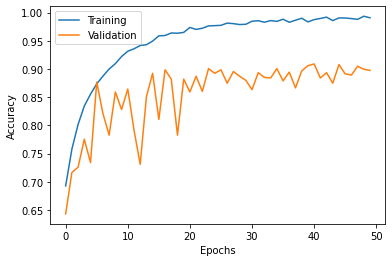

In [32]:
plt.plot(range(E), h.history['accuracy'], label = 'Training')
plt.plot(range(E), h.history['val_accuracy'], label = 'Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('acc.png')
plt.show()

In [27]:
#I plot the loss for the training and validation data sets.

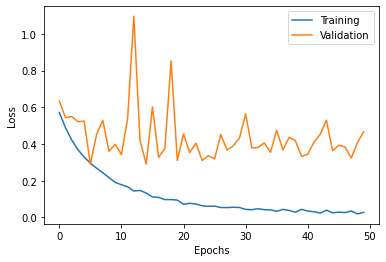

In [33]:
plt.plot(range(E), h.history['loss'], label = 'Training')
plt.plot(range(E), h.history['val_loss'], label = 'Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('loss.png')
plt.show()

In [29]:
#Finally, I test the model's accuracy on the test sets.  The referenced paper
#finds

In [30]:
loss, acc = model.evaluate(x_test, y_test)
print('Test set accuracy: ', acc *100)

31/31 [==============================] - 17s 556ms/step - loss: 0.4667 - accuracy: 0.8975
Test set accuracy:  89.75155353546143
